In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def plummer_force(reb_sim):
    sim = reb_sim.contents
    particles = sim.particles

    GM = 1.0
    a = 1.0
    eps2 = 1e-8

    for p in particles[1:]:
        r2 = p.x*p.x + p.y*p.y + p.z*p.z + eps2
        fac = -GM / (r2 + a*a)**(3/2)

        p.ax += fac * p.x
        p.ay += fac * p.y
        p.az += fac * p.z

In [21]:
def hernquist_force(reb_sim):
    sim = reb_sim.contents
    particles = sim.particles

    GM = 1.0
    a = 1.0

    for p in particles[1:]:
        r = np.sqrt(p.x*p.x + p.y*p.y + p.z*p.z)
        if r == 0:
            continue

        fac = -GM / (r * (r + a)**2)
        p.ax += fac * p.x
        p.ay += fac * p.y
        p.az += fac * p.z


In [22]:
def sample_plummer_positions(N, a=1.0):
    X = np.random.random(N)
    r = a / np.sqrt(X**(-2/3) - 1)

    theta = np.arccos(1 - 2*np.random.random(N))
    phi = 2*np.pi*np.random.random(N)

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return x, y, z

In [23]:
def sample_velocities(x, y, z, GM=1.0, a=1.0):
    r = np.sqrt(x**2 + y**2 + z**2)
    sigma = np.sqrt(GM / (r + a))

    vx = np.random.normal(0, sigma)
    vy = np.random.normal(0, sigma)
    vz = np.random.normal(0, sigma)

    return vx, vy, vz

In [32]:
def run_simulation(force_function, t_end=50.0, N=2000):
    sim = rebound.Simulation()
    sim.G = 1.0
    sim.integrator = "ias15"   # <-- REQUIRED
    sim.dt = 0.02              # dt is advisory for IAS15

    # Dummy particle at origin
    sim.add(m=0)

    x, y, z = sample_plummer_positions(N)
    for i in range(N):
        vx, vy, vz = sample_velocities(x[i], y[i], z[i])
        sim.add(x=x[i], y=y[i], z=z[i], vx=vx, vy=vy, vz=vz)

    sim.additional_forces = force_function
    sim.integrate(t_end)

    return sim


In [33]:
sim_core = run_simulation(plummer_force)
sim_cusp = run_simulation(hernquist_force)

In [34]:
def extract_data(sim, rmin=1e-6):
    rs, vrs = [], []

    for p in sim.particles[1:]:
        r = np.sqrt(p.x*p.x + p.y*p.y + p.z*p.z)

        if r < rmin:
            continue  # skip particles too close to center

        vr = (p.x*p.vx + p.y*p.vy + p.z*p.vz) / r
        rs.append(r)
        vrs.append(vr)

    return np.array(rs), np.array(vrs)

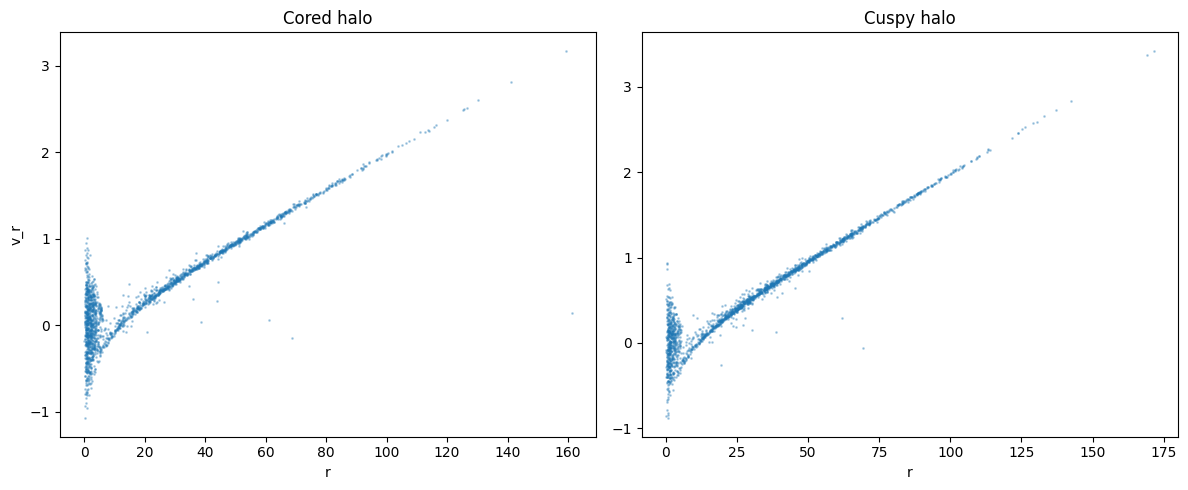

In [35]:
r_core, vr_core = extract_data(sim_core)
r_cusp, vr_cusp = extract_data(sim_cusp)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(r_core, vr_core, s=1, alpha=0.3)
plt.xlabel("r")
plt.ylabel("v_r")
plt.title("Cored halo")

plt.subplot(1,2,2)
plt.scatter(r_cusp, vr_cusp, s=1, alpha=0.3)
plt.xlabel("r")
plt.title("Cuspy halo")

plt.tight_layout()
plt.show()

In [36]:
def surface_density(r, bins=40):
    R = r
    hist, edges = np.histogram(R, bins=bins)
    Rmid = 0.5*(edges[1:] + edges[:-1])
    area = np.pi*(edges[1:]**2 - edges[:-1]**2)
    return Rmid, hist / area

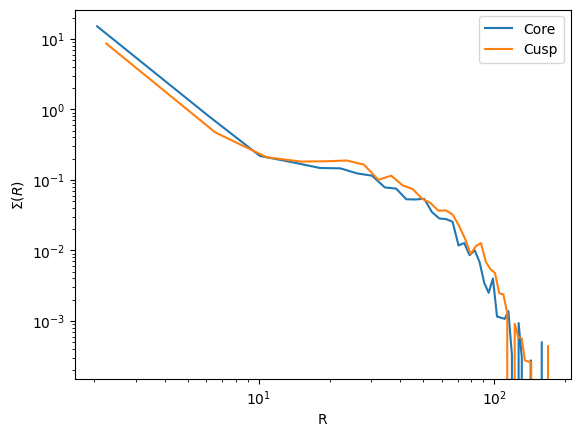

In [39]:
R_core, Sigma_core = surface_density(r_core)
R_cusp, Sigma_cusp = surface_density(r_cusp)

plt.loglog(R_core, Sigma_core, label="Core")
plt.loglog(R_cusp, Sigma_cusp, label="Cusp")
plt.xlabel("R")
plt.ylabel(r"$\Sigma(R)$")
plt.legend()
plt.show()

In [41]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Open the FITS file
hdul = fits.open("asu.fit")

# Inspect the contents
hdul.info()

Filename: asu.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   ()      
  1  J_A_A_635_A107_eri2    1 TableHDU        40   35R x 7C   [I7, F9.5, F9.5, F4.1, F5.1, F4.1, I8]   


In [42]:
data = hdul[1].data

In [43]:
sep = data["Sep"]        # arcsec
rv = data["RV"]          # km/s
erv = data["e_RV"]       # km/s

In [44]:
mask = np.isfinite(sep) & np.isfinite(rv)
sep = sep[mask]
rv = rv[mask]
erv = erv[mask]

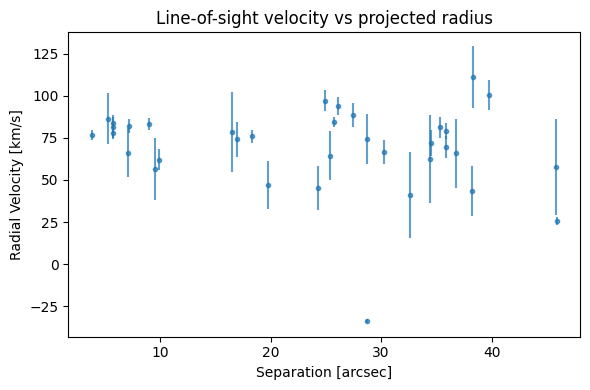

In [45]:
plt.figure(figsize=(6, 4))
plt.errorbar(sep, rv, yerr=erv, fmt='o', ms=3, alpha=0.7)
plt.xlabel("Separation [arcsec]")
plt.ylabel("Radial Velocity [km/s]")
plt.title("Line-of-sight velocity vs projected radius")
plt.tight_layout()
plt.show()